# Clustering de perfiles de OkCupid
Este notebook muestra el proceso de análisis, preprocesamiento y entrenamiento de modelos para agrupar perfiles similares de la web de citas OkCupid.

## 1. Setup

Librerías importadas en el proyecto.

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import os

from IPython.display import IFrame

%matplotlib inline

Variables globales declaradas en el proyecto.

In [3]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

#!git clone https://github.com/dietrujillo/ml_lab.git ./ml_lab
# os.path.join(os.curdir, "ml_lab", "lab3", "data")  # Path to csv data
DATA_PATH = os.path.join(os.pardir, "data")
# os.path.join(os.curdir, "ml_lab", "lab3", "info")  # Path to problem info
INFO_PATH = os.path.join(os.pardir, "info")
# os.path.join(os.curdir, "ml_lab", "lab3", "results")  # Path to results files
RESULTS_PATH = os.path.join(os.pardir, "results")

Enunciado del problema.

In [3]:
# Jupyter Notebook only
IFrame(os.path.join(INFO_PATH, "lab3.pdf"), width=1080, height=920)

## 2. Análisis exploratorio de los datos

In [6]:
dataset = pd.read_csv(os.path.join(DATA_PATH, "okcupid_profiles.csv"))

In [7]:
dataset.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


In [12]:
dataset.dtypes

age              int64
status          object
sex             object
orientation     object
body_type       object
diet            object
drinks          object
drugs           object
education       object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
offspring       object
pets            object
religion        object
sign            object
smokes          object
speaks          object
essay0          object
essay1          object
essay2          object
essay3          object
essay4          object
essay5          object
essay6          object
essay7          object
essay8          object
essay9          object
dtype: object

La codificación de los tipos de las variables es correcta, por lo que no será necesario hacer ninguna transformación de tipos. Se tienen variables numéricas, categóricas y textuales, que se analizaran paso por paso. 

Sin embargo, llegados a este punto podemos prescindir de una variable que no será de utilidad a la hora de hacer el clustering. Esta variable es `last_online`, que repesenta la fecha y hora de última conexión. Con esta decisión reducimos el volumen de datos y nos centramos en las columnas numéricas y categóricas que aportan información sobre la personalidad, preferencias o apariencia física de una persona.

In [71]:
del dataset["last_online"]

### 2.1 Análisis de variables numéricas

In [72]:
numerical_vars = ["age", "height", "income"]

In [73]:
dataset.describe()

,age,height,income
count,59946.000000,59943.000000,59946.000000
mean,32.340290,68.295281,20033.222534
std,9.452779,3.994803,97346.192104
min,18.000000,1.000000,-1.000000
25%,26.000000,66.000000,-1.000000
50%,30.000000,68.000000,-1.000000
75%,37.000000,71.000000,-1.000000
max,110.000000,95.000000,1000000.000000


En este punto ya podemos observar como hay algunos datos numéricos un tanto extraños:
* La edad máxima es 110, lo cual hace dudar que sea un dato correcto. Posiblemente esta edad corresponda con personas que no quieren compartir su edad verdadera.
* La altura parece estar en pulgadas, *inches*, la media es 68 que se corresponde con 172 cm aprox. En este sentido vemos que la altura mínima es 1 pulgada y que la máxima es de 95 (241 cm). Según la lista de personas más altas del mundo publicada en Wikipedia [1], una altura de entorno a 90 pulgadas(230 cm) ya es algo inaudito.
* Los ingresos llaman la atención en tanto que el ingreso mínimo es -1 y el percentil 75 también es -1. Esto indica que al menos el 75% de los usuarios de la aplicación no han querido decir sus ingresos.

In [74]:
dataset[dataset["height"] > 90]["height"]

402      91.0
2569     95.0
3016     95.0
8089     95.0
12181    93.0
17949    95.0
22358    95.0
23760    94.0
25324    95.0
27506    91.0
33640    95.0
33885    95.0
33946    95.0
34607    95.0
34672    94.0
41939    95.0
43452    95.0
44096    95.0
44264    91.0
47621    92.0
48304    95.0
49194    95.0
51714    95.0
53469    95.0
55172    95.0
56931    95.0
57978    95.0
58147    94.0
Name: height, dtype: float64

In [75]:
dataset[dataset["age"] > 80]

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
2512,110,single,f,straight,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25324,109,available,m,straight,athletic,mostly other,NaN,never,working on masters program,NaN,...,NaN,NaN,NaN,nothing,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
(len(dataset[dataset["income"] < 0]) / len(dataset)) * 100

80.80939512227671

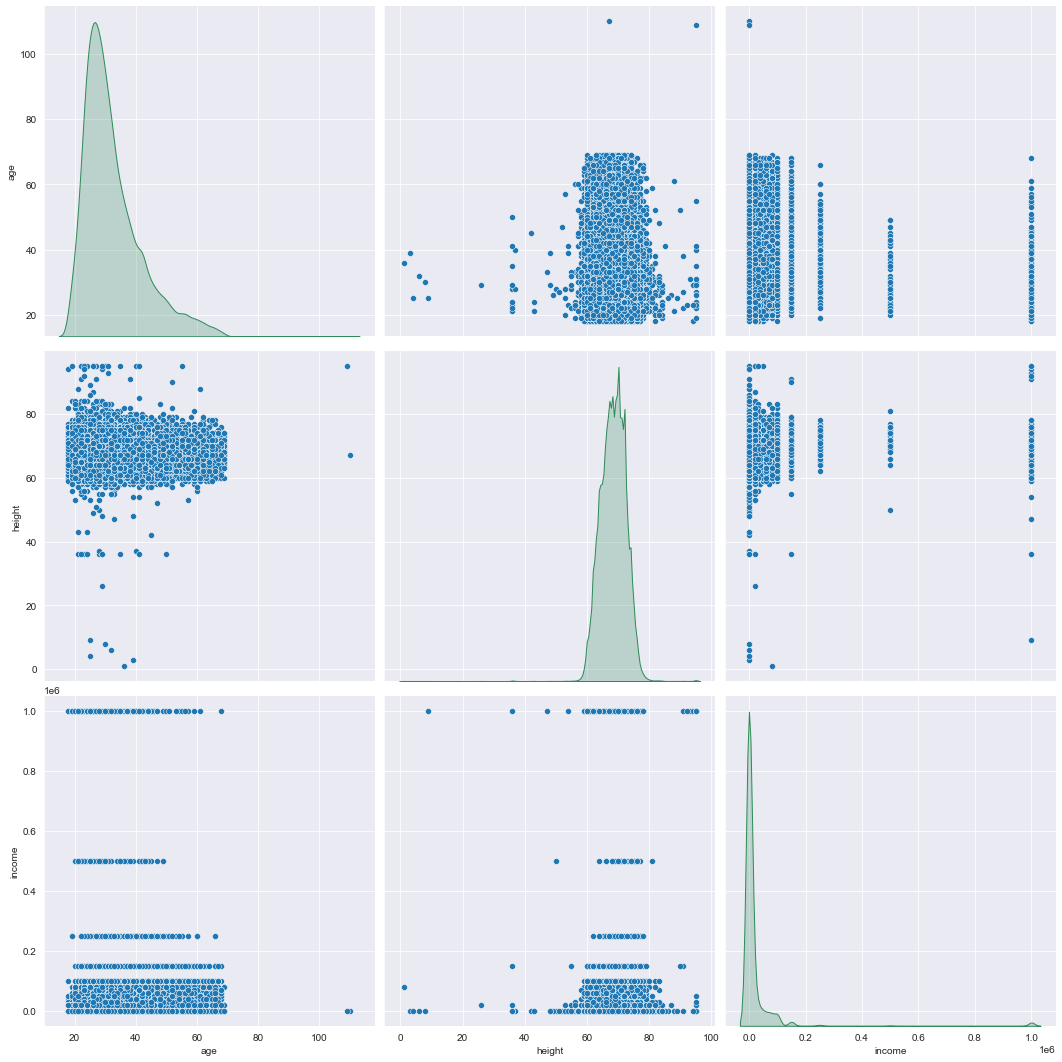

In [77]:
sns.set_style("darkgrid")
sns.pairplot(dataset, vars=numerical_vars, diag_kind="kde",
             diag_kws={"color": "seagreen"}, height=5)
plt.show()

In [113]:
categorical_vars = ["status", "sex", "orientation", "body_type", "diet", "drinks", "drugs", "education",
                    "ethnicity", "job", "location", "offspring", "pets", "religion", "sign", "smokes", "speaks"]

categorical_dict = {}

for var in categorical_vars:
    categorical_dict[var] = dataset[var].unique().tolist()

In [114]:
categorical_dict

{'status': ['single', 'available', 'seeing someone', 'married', 'unknown'],
 'sex': ['m', 'f'],
 'orientation': ['straight', 'bisexual', 'gay'],
 'body_type': ['a little extra',
  'average',
  'thin',
  'athletic',
  'fit',
  nan,
  'skinny',
  'curvy',
  'full figured',
  'jacked',
  'rather not say',
  'used up',
  'overweight'],
 'diet': ['strictly anything',
  'mostly other',
  'anything',
  'vegetarian',
  nan,
  'mostly anything',
  'mostly vegetarian',
  'strictly vegan',
  'strictly vegetarian',
  'mostly vegan',
  'strictly other',
  'mostly halal',
  'other',
  'vegan',
  'mostly kosher',
  'strictly halal',
  'halal',
  'strictly kosher',
  'kosher'],
 'drinks': ['socially',
  'often',
  'not at all',
  'rarely',
  nan,
  'very often',
  'desperately'],
 'drugs': ['never', 'sometimes', nan, 'often'],
 'education': ['working on college/university',
  'working on space camp',
  'graduated from masters program',
  'graduated from college/university',
  'working on two-year coll

De esta primera extracción de los valores, podemos darnos cuenta de que algunas variables encajan mejor con un tipo de variable textual, en lugar de categórica con valores definidos. Veamos que variables contienen más de 15 valores diferentes:

In [121]:
textual_vars = []

for var in categorical_dict:
    if len(categorical_dict[var]) > 15:
        textual_vars.append(var)
        print(var)

diet
education
ethnicity
job
location
offspring
pets
religion
sign
speaks


In [122]:
[categorical_dict.pop(x, None) for x in textual_vars]

[['strictly anything',
  'mostly other',
  'anything',
  'vegetarian',
  nan,
  'mostly anything',
  'mostly vegetarian',
  'strictly vegan',
  'strictly vegetarian',
  'mostly vegan',
  'strictly other',
  'mostly halal',
  'other',
  'vegan',
  'mostly kosher',
  'strictly halal',
  'halal',
  'strictly kosher',
  'kosher'],
 ['working on college/university',
  'working on space camp',
  'graduated from masters program',
  'graduated from college/university',
  'working on two-year college',
  nan,
  'graduated from high school',
  'working on masters program',
  'graduated from space camp',
  'college/university',
  'dropped out of space camp',
  'graduated from ph.d program',
  'graduated from law school',
  'working on ph.d program',
  'two-year college',
  'graduated from two-year college',
  'working on med school',
  'dropped out of college/university',
  'space camp',
  'graduated from med school',
  'dropped out of high school',
  'working on high school',
  'masters program'

In [127]:
categorical_dict
categorical_vars = list(categorical_dict.keys())
categorical_vars

['status', 'sex', 'orientation', 'body_type', 'drinks', 'drugs', 'smokes']

## Referencias

[1] https://en.wikipedia.org/wiki/List_of_tallest_people